# Import Libraries

In [151]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm

# Options

In [152]:
multiStart = True

# Initialize Paramters

In [153]:
T2_size = 10
TE_size = 64

c_array = 0.4
T2_array = np.linspace(40,160,T2_size)

TE_array = np.linspace(8,8*TE_size,TE_size)

if multiStart:
    starts = 20
else:
    starts = 1

SNR = 1000

iterations = 50

weights_moX = [1,1/100]
weights_biX = [1,1,1/100,1/100]

RSS_array_moX = np.zeros((iterations,T2_array.shape[0]))
RSS_array_biX = np.zeros((iterations,T2_array.shape[0]))

pErr_array_moX = np.zeros((iterations,T2_array.shape[0]))
pErr_array_biX = np.zeros((iterations,T2_array.shape[0]))

RSS_noise_moX = np.zeros((iterations,T2_array.shape[0]))
RSS_noise_biX = np.zeros((iterations,T2_array.shape[0]))

RSS_disconnect_noisey = np.zeros((T2_array.shape[0],1))
pseudo_moX = np.zeros((T2_array.shape[0],1))

details = str('\nTE Points: ' + str(TE_size) + " :: Starts " + str(starts) +
            '\nIterations: ' + str(iterations) + ' :: SNR: ' + str(SNR))

# Signal Functions

In [154]:
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def add_noise(data,SNR):
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

# Curve Fitting

In [155]:
for iT2 in trange(T2_array.shape[0]):

    T2 = T2_array[iT2]
    true_sig = S_moX_2p(TE_array,c_array,T2)

    RSS_disconnect_moX_count = 0
    RSS_disconnect_biX_count = 0

    pseudo_moX_count = 0
    RSS_disconnect_noisey_count = 0


    for iter in range(iterations):

        noised_sig = add_noise(true_sig,SNR)

        paramTemp_moX = np.zeros((starts,2))
        paramTemp_biX = np.zeros((starts,4))
        RSS_Temp_moX = np.ones(starts)*np.inf
        RSS_Temp_biX = np.ones(starts)*np.inf

        RSS_tNoise_moX = np.ones(starts)*np.inf
        RSS_tNoise_biX = np.ones(starts)*np.inf
       

        for start in range(starts):

            lb_moX = (0,1)
            ub_moX = (1,300)

            init_p_moX = tuple(np.add(np.subtract(ub_moX,lb_moX)*np.random.uniform(0,1,np.size(lb_moX)),lb_moX))

            popt_moX, pcov_moX = curve_fit( S_moX_2p, TE_array, noised_sig, p0 = init_p_moX, bounds = [lb_moX,ub_moX], method = 'trf', maxfev = 1500)

            paramTemp_moX[start,:] = popt_moX
            RSS_Temp_moX[start] = np.sum((true_sig - S_moX_2p(TE_array, *popt_moX))**2)
            RSS_tNoise_moX[start] = np.sum((noised_sig - S_moX_2p(TE_array, *popt_moX))**2)

            lb_biX = (0,0,1,1)
            ub_biX = (1,1,300,300)

            init_p_biX = tuple(np.add(np.subtract(ub_biX,lb_biX)*np.random.uniform(0,1,np.size(lb_biX)),lb_biX))

            popt_biX, pcov_biX = curve_fit( S_biX_4p, TE_array, noised_sig, p0 = init_p_biX, bounds = [lb_biX,ub_biX], method = 'trf', maxfev = 1500)

            paramTemp_biX[start,:] = popt_biX
            RSS_Temp_biX[start] = np.sum((true_sig - S_biX_4p(TE_array, *popt_biX))**2)
            RSS_tNoise_biX[start] = np.sum((noised_sig - S_biX_4p(TE_array, *popt_biX))**2)

        RSS_array_moX[iter,iT2] = np.min(RSS_Temp_moX)
        RSS_array_biX[iter,iT2] = np.min(RSS_Temp_biX)

        RSS_noise_moX[iter,iT2] = np.min(RSS_tNoise_moX)
        RSS_noise_biX[iter,iT2] = np.min(RSS_tNoise_biX)

        if (np.min(RSS_tNoise_biX) - np.min(RSS_tNoise_moX)) > 0:
            RSS_disconnect_noisey_count = RSS_disconnect_noisey_count + 1

        pErr_array_moX[iter,iT2] = np.linalg.norm((paramTemp_moX[np.argmin(RSS_Temp_moX),:] - (c_array, T2))*weights_moX)

        if (np.abs(paramTemp_biX[np.argmin(RSS_Temp_biX),2] - paramTemp_biX[np.argmin(RSS_Temp_biX),3]) < 10 and
            np.abs(paramTemp_biX[np.argmin(RSS_Temp_biX),0] + paramTemp_biX[np.argmin(RSS_Temp_biX),1] - c_array) < 0.05):
            pseudo_moX_count += 1

        err1 = np.linalg.norm((paramTemp_biX[np.argmin(RSS_Temp_biX),(1,3)] - (c_array, T2))*weights_moX)
        err2 = np.linalg.norm((paramTemp_biX[np.argmin(RSS_Temp_biX),(0,2)] - (c_array, T2))*weights_moX)
        pErr_array_biX[iter,iT2] = np.min([err1,err2])

    pseudo_moX[iT2] = pseudo_moX_count
    RSS_disconnect_noisey[iT2] = RSS_disconnect_noisey_count


  0%|          | 0/2 [00:00<?, ?it/s]

BiX RSS6.333364923035478e-05
MoX RSS6.333364922972589e-05
BiX RSS4.6892875238377024e-05
MoX RSS4.6892875238239236e-05
BiX RSS5.521498555132698e-05
MoX RSS5.521498555128514e-05
BiX RSS5.570029471239783e-05
MoX RSS5.570029471111509e-05
BiX RSS4.2393571997453606e-05
MoX RSS4.23935719967198e-05
BiX RSS7.970584217725522e-05
MoX RSS7.97058421772414e-05
BiX RSS6.728873281797279e-05
MoX RSS6.728873281790468e-05
BiX RSS5.832890847125092e-05
MoX RSS5.832890846971229e-05
BiX RSS4.784882232316167e-05
MoX RSS4.7848822323148506e-05
BiX RSS6.534975314025538e-05
MoX RSS6.534975314025525e-05
BiX RSS4.682581253714122e-05
MoX RSS4.682581253714044e-05
BiX RSS7.749374026963479e-05
MoX RSS7.749374026963198e-05
BiX RSS6.059083315691082e-05
MoX RSS6.059083315690984e-05
BiX RSS6.829775165463411e-05
MoX RSS6.8297751654634e-05
BiX RSS6.243633476635665e-05
MoX RSS6.243633476630322e-05
BiX RSS6.135635195309009e-05
MoX RSS6.135635195304059e-05
BiX RSS5.168152858211884e-05
MoX RSS5.1681528582040695e-05
BiX RSS6.5688

 50%|█████     | 1/2 [01:58<01:58, 118.43s/it]

BiX RSS7.469551344153542e-05
MoX RSS7.469551344153327e-05
BiX RSS6.506914470108893e-05
MoX RSS6.506914470108005e-05
BiX RSS5.705450292599029e-05
MoX RSS5.705450292598528e-05
BiX RSS6.520202988992139e-05
MoX RSS6.520202988991867e-05
BiX RSS5.500083585246283e-05
MoX RSS5.50008358523855e-05
BiX RSS4.8656510992636533e-05
MoX RSS4.865651099261356e-05
BiX RSS6.365654713708942e-05
MoX RSS6.365654713696083e-05
BiX RSS5.679913659709619e-05
MoX RSS5.679913659709125e-05
BiX RSS6.49743323782119e-05
MoX RSS6.497433237811142e-05
BiX RSS3.696270694632273e-05
MoX RSS3.6962706946320226e-05
BiX RSS6.18119502473228e-05
MoX RSS6.181195024731137e-05
BiX RSS7.13911875807885e-05
MoX RSS7.139118758078825e-05
BiX RSS8.716197605172356e-05
MoX RSS8.716197605170227e-05
BiX RSS5.8578743047038036e-05
MoX RSS5.857874304703284e-05
BiX RSS7.084306692505155e-05
MoX RSS7.084306692504766e-05
BiX RSS5.9613580434030565e-05
MoX RSS5.9613580433982386e-05
BiX RSS6.266318945057808e-05
MoX RSS6.266318945006847e-05


100%|██████████| 2/2 [03:51<00:00, 115.81s/it]


# Graphs

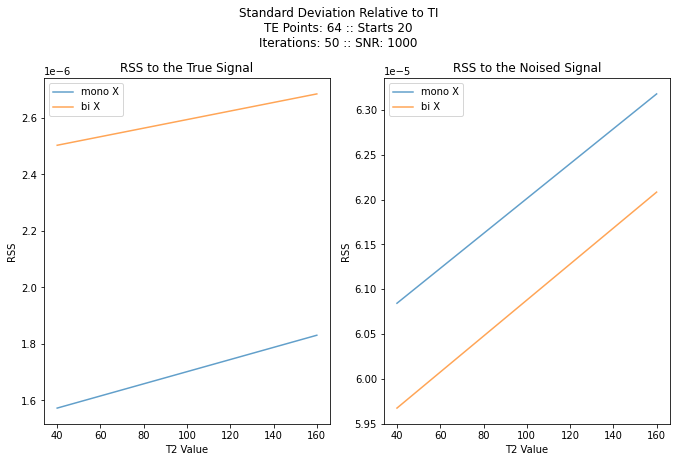

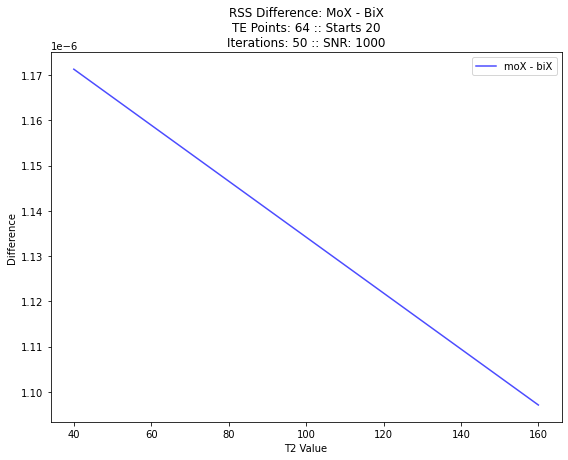

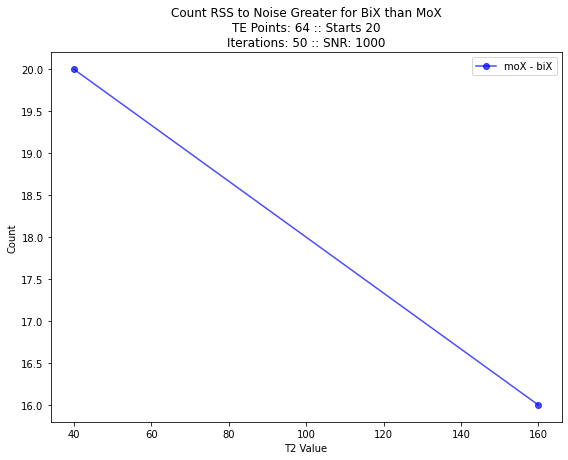

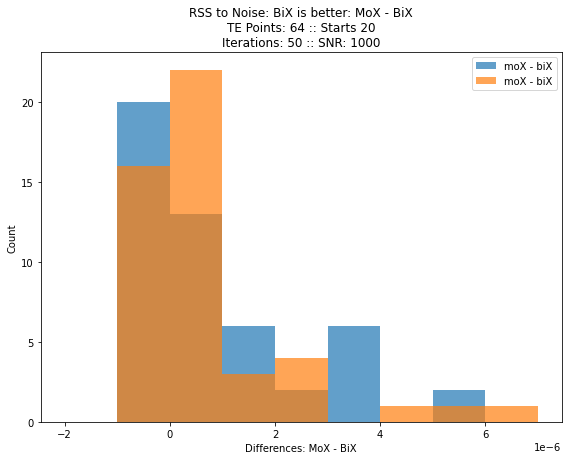

[117.13268999 109.70681276]
MoX
[6.08437279e-05 6.31823274e-05]
biX
[5.96724010e-05 6.20852593e-05]


In [160]:
avg_RSS_moX = np.mean(RSS_array_moX, axis = 0)
avg_RSS_biX = np.mean(RSS_array_biX, axis = 0)
avg_RSS_noise_moX = np.mean(RSS_noise_moX, axis = 0)
avg_RSS_noise_biX = np.mean(RSS_noise_biX, axis = 0)

fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
fig.suptitle('Standard Deviation Relative to TI' + details)

ax[0].plot(T2_array, avg_RSS_moX, label = "mono X", alpha = 0.7)
ax[0].plot(T2_array, avg_RSS_biX, label = "bi X", alpha = 0.7)
ax[0].set_xlabel('T2 Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('RSS to the True Signal')
ax[0].legend()

ax[1].plot(T2_array, avg_RSS_noise_moX, label = "mono X", alpha = 0.7)
ax[1].plot(T2_array, avg_RSS_noise_biX, label = "bi X", alpha = 0.7)
ax[1].set_xlabel('T2 Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS to the Noised Signal')
ax[1].legend()

plt.show()


fig = plt.figure(figsize=(8,6.5), tight_layout=True)

plt.plot(T2_array,avg_RSS_noise_moX - avg_RSS_noise_biX, label = 'moX - biX', alpha = 0.7, color = 'b', ls = '-')
plt.xlabel('T2 Value')
plt.ylabel('Difference')
plt.title('RSS Difference: MoX - BiX' + details)
plt.legend()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(8,6.5), tight_layout=True)

plt.plot(T2_array, RSS_disconnect_noisey, label = 'moX - biX', alpha = 0.7, color = 'b', ls = '-', marker = 'o')
plt.xlabel('T2 Value')
plt.ylabel('Count')
plt.title('Count RSS to Noise Greater for BiX than MoX' + details)
plt.legend()
plt.tight_layout()
plt.show()


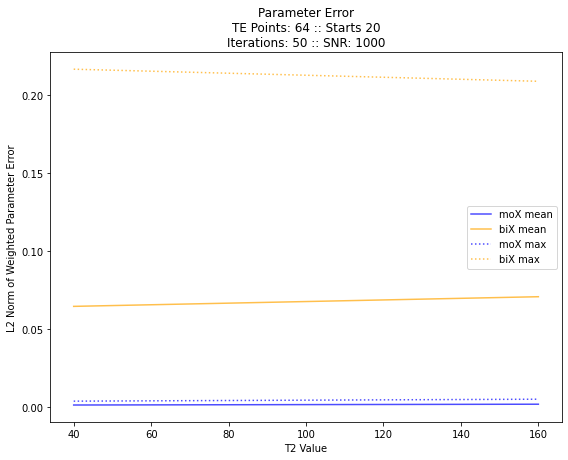

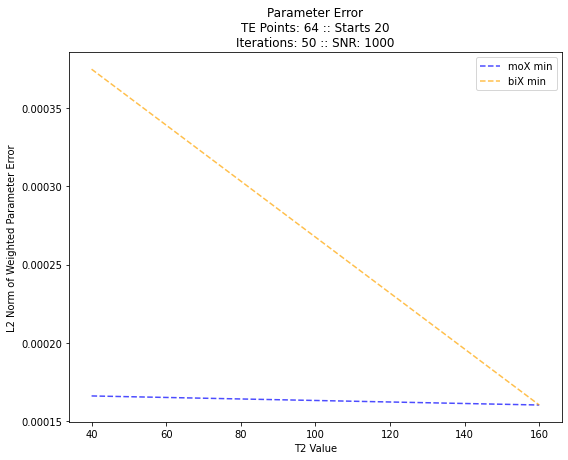

In [ ]:
avg_pErr_moX_mean = np.mean(pErr_array_moX, axis = 0)
avg_pErr_biX_mean = np.mean(pErr_array_biX, axis = 0)

avg_pErr_moX_max = np.max(pErr_array_moX, axis = 0)
avg_pErr_biX_max = np.max(pErr_array_biX, axis = 0)

avg_pErr_moX_min = np.min(pErr_array_moX, axis = 0)
avg_pErr_biX_min = np.min(pErr_array_biX, axis = 0)

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(T2_array,avg_pErr_moX_mean, label = 'moX mean', alpha = 0.7, color = 'b', ls = '-')
plt.plot(T2_array,avg_pErr_biX_mean, label = 'biX mean', alpha = 0.7, color = 'orange', ls = '-')

plt.plot(T2_array,avg_pErr_moX_max, label = 'moX max', alpha = 0.7, color = 'b', ls = ':')
plt.plot(T2_array,avg_pErr_biX_max, label = 'biX max', alpha = 0.7, color = 'orange', ls = ':')

# plt.plot(T2_array,avg_pErr_moX_min, label = 'moX min', alpha = 0.7, color = 'b', ls = '--')
# plt.plot(T2_array,avg_pErr_biX_min, label = 'biX min', alpha = 0.7, color = 'orange', ls = '--')
plt.xlabel('T2 Value')
plt.ylabel('L2 Norm of Weighted Parameter Error')
plt.title('Parameter Error Mean and Max' + details)
plt.legend()
plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(T2_array,avg_pErr_moX_min, label = 'moX min', alpha = 0.7, color = 'b', ls = '--')
plt.plot(T2_array,avg_pErr_biX_min, label = 'biX min', alpha = 0.7, color = 'orange', ls = '--')
plt.xlabel('T2 Value')
plt.ylabel('L2 Norm of Weighted Parameter Error')
plt.title('Parameter Error Minimum' + details)
plt.legend()
plt.tight_layout()
plt.show()


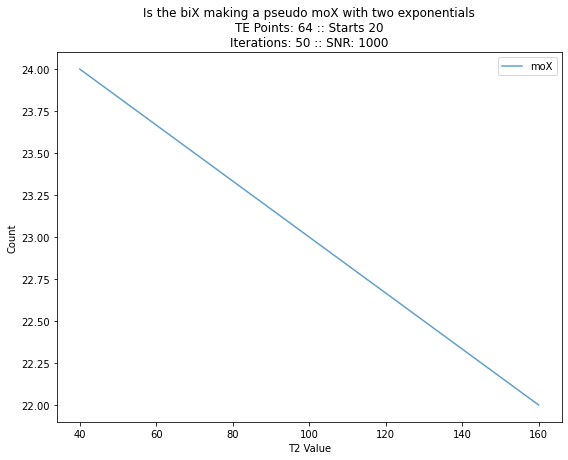

In [ ]:
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(T2_array,pseudo_moX, label = 'moX', alpha = 0.7)
plt.xlabel('T2 Value')
plt.ylabel('Count')
plt.title('Is the biX making a pseudo moX with two exponentials' + details)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(T2_size):    
    fig = plt.figure(figsize=(8,6.5), tight_layout=True)

    bin_manual = np.array([-2,-1,0,1,2,3,4,5,6,7])*10**-6

    plt.hist(x = (RSS_noise_moX[:,i] - RSS_noise_biX[:,0]), bins = bin_manual, label = 'moX - biX', alpha = 0.7)
    plt.xlabel('Differences: MoX - BiX')
    plt.ylabel('Count')
    plt.title('RSS Difference Histogram :: T2 ' + str(T2_array[i]) + details)
    plt.legend()
    plt.tight_layout()
    plt.show()